<a href="https://colab.research.google.com/github/sanghun1210/mlworkshop/blob/main/predict_stock_random_forest_v1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -U numpy
!pip install finance-datareader
import FinanceDataReader as fdr

def get_stock_list():
    try:
        df_krx = fdr.StockListing("KRX")
        return df_krx
    except Exception as e:    
        print("raise error ", e)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import pandas as pd

df_krx = get_stock_list()
sam_df = fdr.DataReader(df_krx['Code'][0], '2020')
sam_df.head()

,Open,High,Low,Close,Volume,Change
Date,,,,,,
2020-01-02,55500,56000,55000,55200,12993228,-0.010753
2020-01-03,56000,56600,54900,55500,15422255,0.005435
2020-01-06,54900,55600,54600,55500,10278951,0.000000
2020-01-07,55700,56400,55600,55800,10009778,0.005405
2020-01-08,56200,57400,55900,56800,23501171,0.017921


,Open,High,Low,Volume,Close
Date,,,,,
2020-01-03,55500,56600,54900,28415483,55500
2020-01-10,54900,59700,54600,83892649,59500
2020-01-17,59600,62000,58900,72973797,61300
2020-01-24,62000,62800,60400,53927668,60800
2020-01-31,59400,59700,56400,80682039,56400


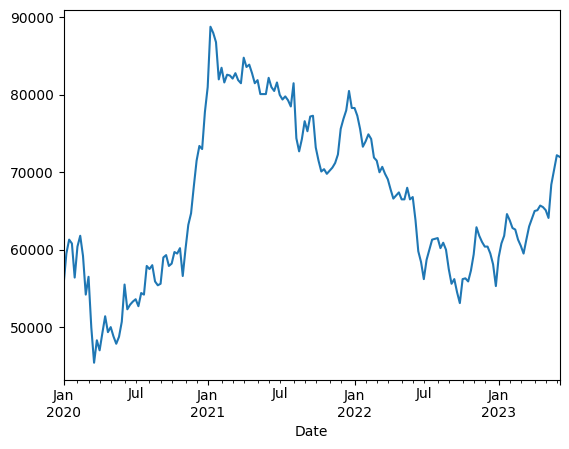

In [3]:
weekly_open = sam_df['Open'].resample('W-FRI').first().ffill()
weekly_high = sam_df['High'].resample('W-FRI').max().ffill()
weekly_low = sam_df['Low'].resample('W-FRI').min().ffill()
weekly_volume = sam_df['Volume'].resample('W-FRI').sum().ffill()
weekly_close = sam_df['Close'].resample('W-FRI').last().ffill()

# 주봉 데이터 프레임 생성
weekly_data = pd.DataFrame({'Open': weekly_open,
                            'High': weekly_high,
                            'Low': weekly_low,
                            'Volume': weekly_volume,
                            'Close': weekly_close})

weekly_data['Close'].plot()
weekly_data.head()



In [4]:

weekly_data['Close_1w_change'] = weekly_data['Close'].pct_change()
weekly_data['Close_1w_future_close'] = weekly_data['Close'].shift(-1)

weekly_data.dropna(inplace=True)
weekly_data['is_futrue_rise'] = weekly_data['Close_1w_future_close'] > weekly_data['Close'] 
weekly_data_org = weekly_data.copy()
weekly_data.head()


,Open,High,Low,Volume,Close,Close_1w_change,Close_1w_future_close,is_futrue_rise
Date,,,,,,,,
2020-01-10,54900,59700,54600,83892649,59500,0.072072,61300.0,True
2020-01-17,59600,62000,58900,72973797,61300,0.030252,60800.0,False
2020-01-24,62000,62800,60400,53927668,60800,-0.008157,56400.0,False
2020-01-31,59400,59700,56400,80682039,56400,-0.072368,60400.0,True
2020-02-07,55500,61200,55200,96203269,60400,0.070922,61800.0,True


In [5]:
url = 'https://anaconda.org/conda-forge/libta-lib/0.4.0/download/linux-64/libta-lib-0.4.0-h166bdaf_1.tar.bz2'
!curl -L $url | tar xj -C /usr/lib/x86_64-linux-gnu/ lib --strip-components=1
url = 'https://anaconda.org/conda-forge/ta-lib/0.4.19/download/linux-64/ta-lib-0.4.19-py310hde88566_4.tar.bz2'
!curl -L $url | tar xj -C /usr/local/lib/python3.10/dist-packages/ lib/python3.10/site-packages/talib --strip-components=3
import talib

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4271    0  4271    0     0  17795      0 --:--:-- --:--:-- --:--:-- 17795
100  517k  100  517k    0     0   871k      0 --:--:-- --:--:-- --:--:--  871k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  4195    0  4195    0     0  20364      0 --:--:-- --:--:-- --:--:-- 20265
100  392k  100  392k    0     0   727k      0 --:--:-- --:--:-- --:--:--  727k


In [10]:
import talib
import numpy as np

weekly_data = weekly_data_org.copy()
feature_names = []

float_data = [float(x) for x in weekly_data['Close']]
np_float_data = np.array(float_data)
for n in [5, 14, 20]:
    weekly_data['ma' + str(n)] = talib.SMA(np_float_data, timeperiod=n)
    weekly_data['rsi' + str(n)] = talib.RSI(np_float_data, timeperiod=n)

    feature_names = feature_names + ['ma' + str(n), 'rsi' + str(n)]

# weekly_data['MACD'] = talib.MACD(weekly_data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)[0] / \
#                      talib.MACD(weekly_data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)[0].mean()

weekly_data['MACD'], weekly_data['MACD_SIGNAL'], weekly_data['MACD_HISTOGRAM'] = talib.MACD(weekly_data['Close'], fastperiod=12, slowperiod=26, signalperiod=9)
    
weekly_data['Volume_1d_change'] = weekly_data['Volume'].pct_change()
volume_features = ['Volume_1d_change']
feature_names.extend(volume_features)
weekly_data.dropna(inplace=True)
weekly_data.head()

print(weekly_data['MACD_HISTOGRAM'])


Date
2020-08-28    1013.131601
2020-09-04     845.077895
2020-09-11     916.966270
2020-09-18     935.552475
2020-09-25     809.133251
                 ...     
2023-05-05     441.710870
2023-05-12     302.430593
2023-05-19     465.712343
2023-05-26     655.850765
2023-06-02     851.360241
Freq: W-FRI, Name: MACD_HISTOGRAM, Length: 145, dtype: float64


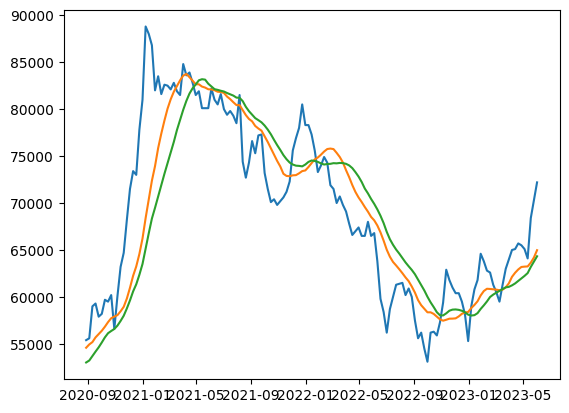

In [8]:
import matplotlib.pyplot as plt

plt.plot(weekly_data['Close'])
plt.plot(weekly_data['ma14'])
plt.plot(weekly_data['ma20'])
plt.show()

In [15]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

#sam_df.dropna(inplace=True)
#sam_df = sam_df[np.isfinite(sam_df).all(1)]

data = weekly_data[['Open', 'High', 'Low', 'Volume', 'Close', 'MACD_HISTOGRAM', 'ma5']].to_numpy()
print(data.shape)

target = weekly_data['is_futrue_rise'].to_numpy()
# print(target.shape)
train_input, test_input, train_target, test_target = train_test_split(data, target, test_size=0.2, shuffle=False)
# print(train_input.shape)
# print(train_target.shape)
# print(train_target)


(145, 7)


In [16]:
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

# ss = StandardScaler()
# ss.fit(train_input)
# train_scaled = ss.transform(train_input)
# test_scaled = ss.transform(test_input)
# print(train_scaled.shape)

rf = RandomForestClassifier(n_jobs=-1)
scores = cross_validate(rf, train_input, train_target, return_train_score=True, n_jobs=-1)
print(np.mean(scores['train_score']), np.mean(scores['test_score']))

1.0 0.4822463768115942
